In [1]:
import pandas as pd
import psutil
from toolz import curry
## Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
def demean(df, group_vars, vars_to_demean):
    """
    Demean variables by group variables (fixed effects).
    
    Args:
        df (pd.DataFrame): The dataframe containing the data.
        group_vars (list of str): List of column names representing the fixed effect variables.
        vars_to_demean (list of str): List of variables to demean.
        
    Returns:
        df_demeaned (pd.DataFrame): DataFrame with demeaned variables.
    """
    df_demeaned = df.copy()
    
    # Group by the fixed effect variables and calculate group means
    group_means = df.groupby(group_vars, observed=True)[vars_to_demean].transform('mean')
    
    # Subtract the group means from the original variables to demean
    df_demeaned[vars_to_demean] = df[vars_to_demean] - group_means
    
    return df_demeaned

In [3]:
@curry
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [4]:
# Get the virtual memory details
memory_info = psutil.virtual_memory()
total_memory = memory_info.total
available_memory = memory_info.available
used_memory = memory_info.used

print(f"Total Memory: {total_memory / (1024 ** 3):.2f} GB")
print(f"Available Memory: {available_memory / (1024 ** 3):.2f} GB")
print(f"Used Memory: {used_memory / (1024 ** 3):.2f} GB")

Total Memory: 7.45 GB
Available Memory: 0.79 GB
Used Memory: 6.66 GB


In [5]:
df = pd.read_csv("./Final Data/analysis_input3.csv")
df = df.dropna(subset=['overlap']).dropna()

In [6]:
df['branch_closures_tract_binary'] = [1 if x>0 else 0 for x in df['branch_closures_tract'] ]

In [7]:
# Step 2: Create event_year variable
df['event_year'] = df['year'] - df['EFFDATE']

# Step 3: Preserve, then generate close_2yr
df['close_2yr'] = 0
df.loc[((df['event_year'] == 0) | (df['event_year'] == 1)), 'close_2yr'] = df['branch_closures_tract_binary'] #(df['event_year'] == 0) | 

# Collapse (taking max of 'close_2yr') and group by relevant columns
df_collapsed = df.groupby(['state', 'county', 'tract', 'overlap', 'mergerID']).agg({'close_2yr': 'max'}).reset_index()
tempclose2 = df_collapsed.copy()
# Merge the collapsed dataframe back into the original one
df.drop(columns=['close_2yr'], inplace=True)
df = df.merge(tempclose2, on=['state', 'county', 'tract', 'overlap', 'mergerID'], how='left')

In [8]:
# Step 4: Generate POST, POST_close, and POST_expose variables
df['POST'] = (df['event_year'] > 0).astype(int)
df['POST_close'] = df['POST'] * df['close_2yr']
df['POST_expose'] = df['POST'] * df['overlap']

# Step 4: Generate year dummies (ydum1999 to ydum2013)
for year in range(2010, 2023):
    df[f'ydum{year}'] = (df['year'] == year).astype(int)
    
# Step 5: Interact control variables with year dummies
control_vars = ['poptot', 'popden', 'pminority', 'pcollege', 'medincome', 'total_branches_county', 'avg_branch_growth_county']


# Step 7: Create group variables
df['group_timeID'] = pd.Categorical(pd.factorize(df[['state', 'county', 'year']].apply(tuple, axis=1))[0])
df['indivID'] = pd.Categorical(pd.factorize(df[['state', 'county', 'tract']].apply(tuple, axis=1))[0])
df['clustID'] = pd.Categorical(pd.factorize(df[['state', 'county']].apply(tuple, axis=1))[0])

In [9]:
df_dowhy = df.dropna(subset = ['branch_closures_tract_binary', 'total_branches_tract', 'sbl_total', 'POST_close', 'POST_expose', 'avg_branch_growth_tract'] + control_vars)

In [10]:
df_dowhy

,year,state,county,tract,num_100k,vol_100k,num_250k,vol_250k,num_1mil,vol_1mil,...,ydum2016,ydum2017,ydum2018,ydum2019,ydum2020,ydum2021,ydum2022,group_timeID,indivID,clustID
0,2010,36,119,4600.0,140.0,1507.170060,3.0,621.465969,4.0,1876.366880,...,0,0,0,0,0,0,0,0,0,0
1,2018,36,119,4600.0,252.0,3080.456776,7.0,970.323803,9.0,3029.048892,...,0,0,1,0,0,0,0,1,0,0
2,2021,36,119,7402.0,187.0,2256.747561,8.0,888.078659,10.0,3393.806707,...,0,0,0,0,0,1,0,2,1,0
3,2007,36,119,9300.0,720.0,8671.681101,16.0,2756.376366,21.0,10450.980170,...,0,0,0,0,0,0,0,3,2,0
4,2009,36,119,9300.0,312.0,3265.009250,9.0,1464.301515,13.0,5539.489077,...,0,0,0,0,0,0,0,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,2017,51,87,200119.0,435.0,6383.322186,16.0,2257.366661,30.0,12866.498880,...,0,1,0,0,0,0,0,399,272,80
645,2018,51,87,200119.0,473.0,7026.011842,13.0,1870.765014,20.0,7873.438674,...,0,0,1,0,0,0,0,400,272,80
646,2021,51,87,200119.0,593.0,7982.575000,46.0,5172.859146,46.0,17309.210366,...,0,0,0,0,0,1,0,396,272,80
647,2021,51,153,901509.0,167.0,1908.609146,5.0,605.080488,3.0,964.075610,...,0,0,0,0,0,1,0,401,273,81


In [11]:
y_train = df_dowhy["POST_close"] # POST_close
T_train = df_dowhy["POST_expose"]# POST_expose
X_train = df_dowhy[control_vars]

X_sim = X_train.copy()
X_sim['total_branches_county'] = X_sim['total_branches_county']*0.1
#y_test = test["POST_close"] #branch_closures_tract
#T_test = test["POST_expose"]
#X_test = test[control_vars]

### Simulate Underbankded/Underserved Communities

### 2.2. Train Estimator

In [12]:
est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestClassifier(min_samples_leaf=10),
                discrete_treatment=True,
                cv=6)
est.fit(y_train, T_train, X=X_train, W=None)
te_pred = est.effect(X_train)
lb, ub = est.effect_interval(X_train, alpha=0.01)

In [13]:
te_pred_sim = est.effect(X_sim)
lb_sim, ub_sim = est.effect_interval(X_train, alpha=0.01)

In [14]:
est3 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(min_samples_leaf=10),
                       discrete_treatment=True,
                       n_estimators=500,
                       verbose=0,
                       cv=6)
est3.tune(y_train, T_train, X=X_train, W=None)
est3.fit(y_train, T_train, X=X_train, W=None)
te_pred3 = est3.effect(X_train)
lb3, ub3 = est3.effect_interval(X_train, alpha=0.01)

In [15]:
te_pred3_sim3 = est3.effect(X_sim)
lb_sim3, ub_sim3 = est3.effect_interval(X_train, alpha=0.01)

### 2.3. Performance Visualization

In [16]:
plot_df = X_train.copy()
plot_df2 = X_train.copy()
plot_df3 = X_train.copy()

plot_df = plot_df.assign(te_pred_sim=te_pred_sim, te_pred=te_pred, lb=lb, ub=ub, overlap = df_dowhy['overlap'], branch_closures_tract_binary = df_dowhy['branch_closures_tract_binary'], avgGrowth = df_dowhy['avg_branch_growth_tract'], tot_branch = df_dowhy['total_branches_tract'], POST_close = df_dowhy['POST_close'], POST_expose = df_dowhy['POST_expose'])
plot_df3 = plot_df.assign(te_pred3_sim3=te_pred3_sim3, te_pred3=te_pred3, lb3=lb3, ub3=ub3, overlap = df_dowhy['overlap'], branch_closures_tract_binary = df_dowhy['branch_closures_tract_binary'] , avgGrowth = df_dowhy['avg_branch_growth_tract'], tot_branch = df_dowhy['total_branches_tract'], POST_close = df_dowhy['POST_close'], POST_expose = df_dowhy['POST_expose'])

plot_df.sort_values(by='te_pred', ascending=True, inplace=True)
plot_df3.sort_values(by='te_pred3', ascending=True, inplace=True)

In [17]:
te_pred.mean()

In [18]:
te_pred_sim.mean()

In [19]:
te_pred3.mean()

In [20]:
te_pred3_sim3.mean()

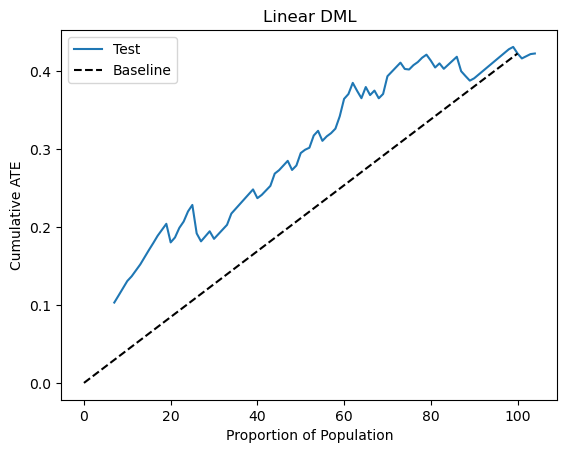

In [21]:
gain_curve_test = cumulative_gain(plot_df, 'te_pred', y='POST_close', t='POST_expose')
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(plot_df, 'POST_close', 'POST_expose')], linestyle="--", color="black", label="Baseline")
plt.xlabel('Proportion of Population')
plt.ylabel('Cumulative ATE')
plt.legend();
plt.title("Linear DML");

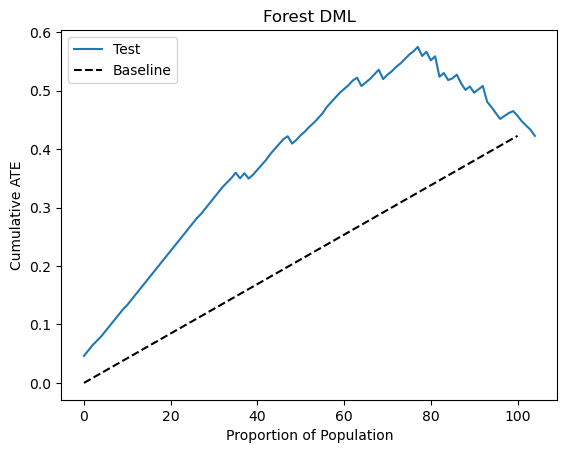

In [22]:
gain_curve_test = cumulative_gain(plot_df3, 'te_pred3', y='POST_close', t='POST_expose')
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(plot_df3, 'POST_close', 'POST_expose')], linestyle="--", color="black", label="Baseline")
plt.xlabel('Proportion of Population')
plt.ylabel('Cumulative ATE')
plt.legend();
plt.title("Forest DML");

In [31]:
from sklearn.linear_model import LinearRegression

x1 = plot_df['tot_branch'].values.reshape(-1, 1)
x3 = plot_df3['tot_branch'].values.reshape(-1, 1)

# Linear regression for the first plot
y1 = te_pred_sim
model1 = LinearRegression().fit(x1, y1)
line1 = model1.predict(x1)

# Linear regression for the second plot
y2 = te_pred3_sim3
model2 = LinearRegression().fit(x3, y2)
line2 = model2.predict(x3)

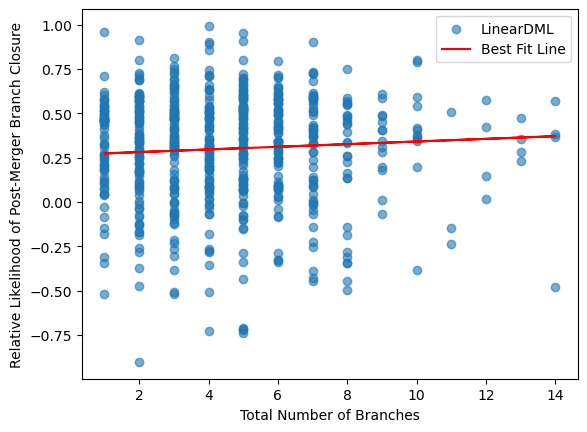

In [32]:
#expected_te=np.array([exp_te(x_i) for x_i in X_test])
plt.scatter(plot_df3['tot_branch'], te_pred_sim, label='LinearDML', alpha=.6)
plt.plot(plot_df['tot_branch'], line1, color='red', label='Best Fit Line')
plt.ylabel('Relative Likelihood of Post-Merger Branch Closure')
plt.xlabel('Total Number of Branches')
plt.legend()
plt.show()

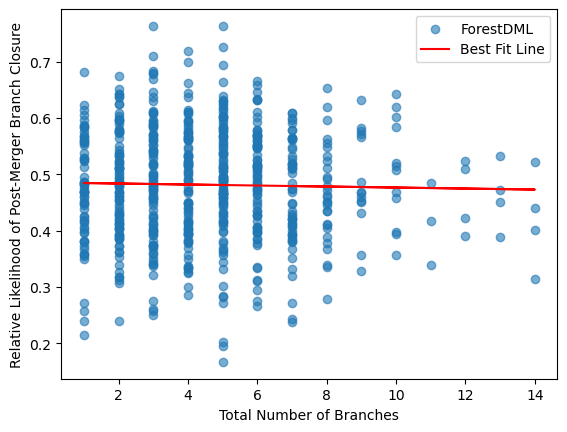

In [33]:
plt.scatter(plot_df3['tot_branch'], te_pred3_sim3, label='ForestDML', alpha=.6)
plt.plot(plot_df3['tot_branch'], line2, color='red', label='Best Fit Line')
plt.ylabel('Relative Likelihood of Post-Merger Branch Closure')
plt.xlabel('Total Number of Branches')
plt.legend()
plt.show()

### 2.4 Interpretability with SHAP Values

Explain the heterogeneity model for the constant marginal effect of the treatment using <a href="https://shap.readthedocs.io/en/latest/">SHAP values</a>.

In [27]:
import shap

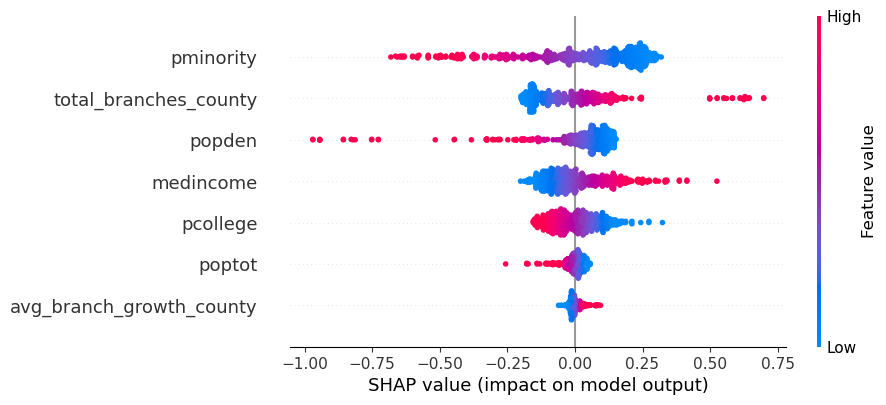

In [28]:
shap_values = est.shap_values(X_train)
shap.plots.beeswarm(shap_values['POST_close']['POST_expose_1.0'])

In [29]:
shap_values2 = est2.shap_values(X_train)
shap.plots.beeswarm(shap_values2['POST_close']['POST_expose_1.0'])

NameError: name 'est2' is not defined

### 2.5. Other Inferences
#### 2.5.1 Effect Inferences
Other than confidence interval, we could also output other statistical inferences of the effect include standard error, z-test score and p value given each sample $X[i]$.

In [ ]:
est.effect_inference(X_train).summary_frame(alpha=0.1, value=0, decimals=3)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,0.481,0.064,7.509,0.0,0.376,0.587
1,0.478,0.063,7.567,0.0,0.374,0.582
2,0.469,0.062,7.611,0.0,0.368,0.571
3,0.486,0.067,7.199,0.0,0.375,0.597
4,0.499,0.074,6.709,0.0,0.377,0.621
...,...,...,...,...,...,...
4300,0.670,0.104,6.439,0.0,0.499,0.841
4301,0.663,0.104,6.386,0.0,0.492,0.833
4302,0.663,0.103,6.431,0.0,0.493,0.833


We could also get the population inferences given sample $X$.

In [ ]:
est.effect_inference(X_train).population_summary(alpha=0.1, value=0, decimals=3, tol=0.001)

#### 2.5.2 Coefficient and Intercept Inferences
We could also get the coefficient and intercept inference for the final model when it's linear.

In [ ]:
est.coef__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
poptot,-0.000,0.000,-2.231,0.026,-0.000,-0.000
popden,-0.000,0.000,-1.018,0.309,-0.000,0.000
pminority,0.003,0.001,2.465,0.014,0.001,0.006
pcollege,-0.415,0.289,-1.439,0.150,-0.981,0.150
medincome,0.000,0.000,0.441,0.659,-0.000,0.000
total_branches_county,0.000,0.000,0.685,0.493,-0.000,0.001
avg_branch_growth_county,0.240,0.281,0.855,0.392,-0.310,0.791


In [ ]:
est.intercept__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
cate_intercept,0.794,0.175,4.529,0.0,0.451,1.138


In [ ]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
poptot,-0.0,0.0,-2.231,0.026,-0.0,-0.0
popden,-0.0,0.0,-1.018,0.309,-0.0,0.0
pminority,0.003,0.001,2.465,0.014,0.001,0.006
pcollege,-0.415,0.289,-1.439,0.15,-0.981,0.15
medincome,0.0,0.0,0.441,0.659,-0.0,0.0
total_branches_county,0.0,0.0,0.685,0.493,-0.0,0.001
avg_branch_growth_county,0.24,0.281,0.855,0.392,-0.31,0.791
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,0.794,0.175,4.529,0.0,0.451,1.138


#### 2.5.3 Doubly Robust Average Treatment Effect Inference

For the case of `CausalForestDML`, the estimator also fits a doubly robust average treatment effect at fit time. This inference result can be accessed as follows:

In [ ]:
est3.ate_

array([3.53511397])

In [ ]:
est3.ate__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,3.535,0.079,44.671,0.0,3.405,3.665
